# Predicting Churn

After discussing the churn problem at TelCo with Henrietta for a while (remember, from your pre-class assignment?), you've finally defined an adequate target variable for churn and gathered relevant data to predict it. Moreover, the marketing department has come up with an amazing retention offer: the offer is guaranteed to convince customers to extend their contract for an extra year after receiving it. Unfortunately, the offer is quite expensive; it costs $200. 

You've been authorized to give the retention offer to up to 25% of the customers whose contract is expiring. It is your job to use data from previous contract expirations to build a churn predictive model and make a recommendation of whom to target with the offers. The historical data includes:

- Gender: Whether the customer is a male or a female
- SeniorCitizen: Whether the customer is a senior citizen or not (1, 0)
- Partner: Whether the customer has a partner or not (Yes, No)
- Dependents: Whether the customer has dependents or not (Yes, No)
- tenure: Number of months the customer has stayed with the company
- PhoneService: Whether the customer has a phone service or not (Yes, No)
- MultipleLines: Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService: Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity: Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup: Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection: Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport: Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV: Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies: Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract: The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling: Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod: The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges: The amount charged to the customer monthly
- Churn: Whether the customer churned or not shortly after contract expiration (Yes or No)

__1. Load the churn data. The code below will also transform your categorical variables into dummy variables. No points for this. This is just meant to help you get started.__

In [1]:
import numpy as np
import pandas as pd

data_path = "./data/data-hw3.csv" 

df = pd.read_csv(data_path)
df = pd.get_dummies(df, drop_first=True)

__2. Split the data into 80% training data and 20% test data.__

In [2]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

__3. Build the best model you can for each of the following three model types:__
- __A decision tree classifier. Try different values for the parameter min_samples_leaf.__
- __A logistic regression. Try different values for the parameter C.__
- __A third model of your choice. Some suggestions: KNN, SVM, etc. Try different paramater values for this one too.__

__Optimize in terms of their generalization performance using ROC Area and cross-validation with 10 folds. Remember to use only the training data (do not use the test data at all for this example). For each of these model types, you should report the best parameter value you found and the corresponding ROC Area in the cross-validation. Your code should also show the process you went through to try different complexity parameter(s) for each model type. Pick one model to move forward with. Why did you select this one?__

__HINT: There is an example below of the ROC Area for a DecisionTreeClassifier using cross validation.__

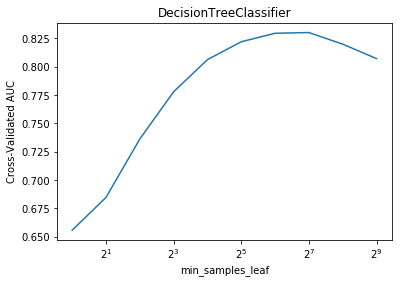

Best DecisionTreeClassifier with min_samples_leaf=128. AUC: 0.83


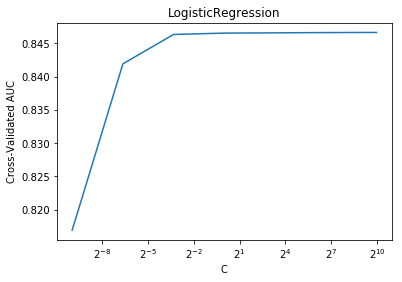

Best LogisticRegression with C=1000.0. AUC: 0.85


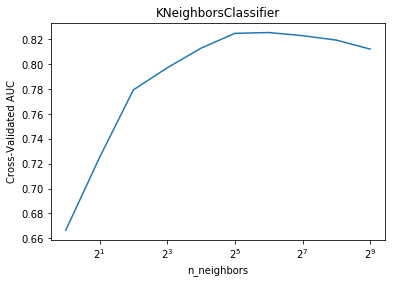

Best KNeighborsClassifier with n_neighbors=64. AUC: 0.83


In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

target = "Churn_Yes"
predictors = df.columns[df.columns != target]

def find_best(data, model_type, param_name, param_vals):
    aucs = list()
    for param_val in param_vals:
        model = model_type(**{param_name: param_val})
        avg_auc = cross_val_score(model, data[predictors], data[target], cv=10, scoring="roc_auc").mean()
        aucs.append(avg_auc)
    # Plot fitting curve
    plt.xscale('log', basex=2)
    plt.plot(param_vals, aucs)
    plt.xlabel(param_name)
    plt.ylabel("Cross-Validated AUC")
    plt.title(model_type.__name__)
    plt.show()
    # Print best
    best_ix = np.argmax(aucs)
    best_auc = aucs[best_ix]
    best_param = param_vals[best_ix]
    print("Best {0} with {1}={2}. AUC: {3}".format(model_type.__name__, param_name, best_param, round(best_auc, 2)))
    return model_type(**{param_name: param_val})

tree_params = np.power(2, range(10))
best_tree = find_best(df_train, DecisionTreeClassifier, "min_samples_leaf", tree_params)
logistic_params = np.power(10.0, range(-3, 4))
best_logistic = find_best(df_train, LogisticRegression, "C", logistic_params)
knn_params = np.power(2, range(10))
best_knn = find_best(df_train, KNeighborsClassifier, "n_neighbors", knn_params)

For now, we choose LogisticRegression with C=1000 because it has the highest generalization performance (according to AUC).

__4. Use your test data to plot the ROC Curves for each of the three best models you found in the previous question (make sure to plot the three curves together). Would you consider changing the selected model after looking at the curves? If yes, explain why. If not, explain what would the curves need to look like for you to consider changing the selected model.__

__HINT: There is an example below of the ROC curve for the DecisionTreeClassifier that was used earlier__

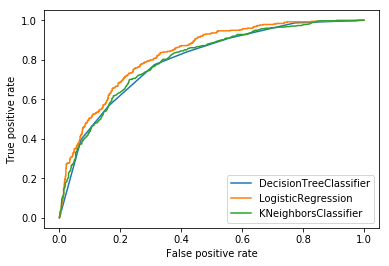

In [4]:
import numpy as np
from sklearn.metrics import roc_curve

for model in [best_tree, best_logistic, best_knn]:
    name = type(model).__name__
    model.fit(df_train[predictors], df_train[target])
    probs = model.predict_proba(df_test[predictors])[:, 1]
    fpr, tpr, thresholds = roc_curve(df_test[target], probs)
    plt.plot(fpr, tpr, label=name)
    
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.legend()
plt.show()    

For my particular models, the ROC curve of the LogisticRegression is always above the curves of the other classifiers, which strengthens our believe that it is the best scoring model. Our decision might have changed if the curves had crossed. Since we only care about targeting up to 25% of the customers, we should choose the model that outperforms the others in the left part of the ROC Curve (the part with low false positives rates). 

__5. What would be the potential benefit of stopping someone from leaving? HINT: Take a look at the description of the data and the retention offer.__

The monthly charges multiplied by 12 (since the retention offer stops someone from leaving for a year) minus $200 (the cost of the retention offer).

__6. Split your training data into two sets, one with 90% of the data (the "sub-training" set) and another with 10% of the data (the validation set). Train the model you selected with the "sub-training" set, apply it to the validation set, and plot a profit curve by ranking customers according to their probability of churning. Make a recommendation of what people to target with the retention incentive according to this profit curve.__

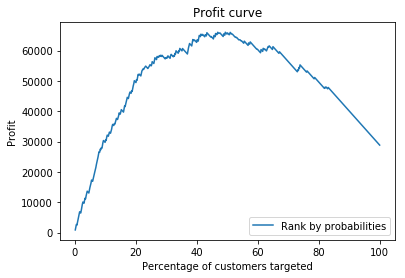

In [5]:
import matplotlib.pyplot as plt


def plot_profit_curve(data, model, rank_by_probs=True):
    # Value that would be lost due to churn.
    retention_cost = 200
    # Offer value per customer
    offer_value = data[target] * data.MonthlyCharges * 12 - retention_cost
    # Get probabilities and expected loss
    probs = model.predict_proba(data[predictors])[:, 1]
    e_loss = probs * data.MonthlyCharges * 12 - retention_cost
    # Rank observations (according to probability of churn or expected loss)
    if rank_by_probs:
        order = np.argsort(probs)[::-1]
        label = "Rank by probabilities"
    else:
        order = np.argsort(e_loss)[::-1]
        label = "Rank by expected loss"
    # Build the profit curve
    cumulative_targets = np.arange(offer_value.size) + 1
    profit_curve = np.cumsum(offer_value.values[order])
    # Plot profit curve
    total_obs = data.shape[0]
    plt.plot(100*cumulative_targets/total_obs, profit_curve, label=label)
    # Other details of the plot
    plt.xlabel("Percentage of customers targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend(loc='best')

# Chosen Model:
df_sub_train, df_validation = train_test_split(df_train, test_size=0.1, random_state=42)
best_logistic.fit(df_sub_train[predictors], df_sub_train[target])
plot_profit_curve(df_validation, model)
plt.show()

In order to maximize profits, and given our budget contraints, we recommend to give the retention offer to the 25% of customers with the largest probability of churning. That said, we should tell our boss that he is missing out! With more budget, we could make more money by targeting the top 40-50%.

__7. Can you think of something better than ranking according to the probability of churning? If so, tell us what it is and plot a profit curve according to this new ranking. Compare the results of the new ranking with the results you got in the previous question. Are the results any better? Would your recommendation change?__

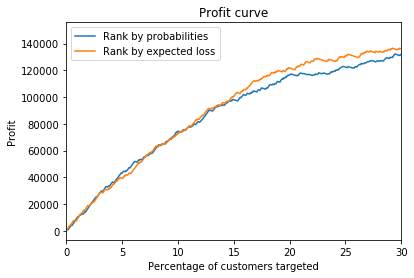

In [6]:
plot_profit_curve(df_test, model)
plot_profit_curve(df_test, model, False)
plt.xlim(xmin=0, xmax=30)
plt.show()

This charts shows that ranking according to expected loss (i.e., the probability of churning multiplied by monthly charges) would give better results when targeting the top 25% of customers. Our recommendation of spending the whole budget would not change, BUT we would recommend to target the customers with the largest expected loss instead. 

__8. Now the you have chosen a model and a threshold, it is time to evaluate the potential impact of your solution. Use the entire training data to train the model you selected, and then use the model on the test data to decide which customers to target with a retention offer. How much money do you estimate that your recommendation would have saved if we had given the retention offer to the customers in the test data?__

In [7]:
def get_profits(data, model, target_per):
    # Value that would be lost due to churn.
    retention_cost = 200
    # Offer value per customer
    offer_value = data[target] * data.MonthlyCharges * 12 - retention_cost
    # Get probabilities and expected loss
    probs = model.predict_proba(data[predictors])[:, 1]
    e_loss = probs * data.MonthlyCharges * 12 - retention_cost
    order = np.argsort(e_loss)[::-1]
    total_targeted = int(len(data) * target_per)
    profits = offer_value.values[order][:total_targeted].sum()
    return profits

# Fit model
best_logistic.fit(df_train[predictors], df_train[target])
target_percentage = 0.25
profits = round(get_profits(df_test, best_logistic, target_per=target_percentage))
print("Total money saved when targeting", str(target_percentage*100) + "%", "of customers: ", "$" + str(profits))
print("Money saved per customer (in the entire data set): ", "$" + str(round(profits / df_test.shape[0])))

Total money saved when targeting 25.0% of customers:  $143606.0
Money saved per customer (in the entire data set):  $102.0
